# Predicting activity based on the gyroscope and accelerometer sensors

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from time import time 
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data processing

In [2]:
# Load training data as dataframe
df = pd.read_csv('final_train.csv')

display(df)

,Unnamed: 0,Activity,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)",energy-mean(),...,tGravityAccMag-energy(),tGravityAccMag-entropy(),tGravityAccMag-iqr(),tGravityAccMag-mad(),tGravityAccMag-max(),tGravityAccMag-mean(),tGravityAccMag-min(),tGravityAccMag-sma(),tGravityAccMag-std(),void()
0,0,STANDING,-1.574191,-0.805700,-2.453831,-1.861714,0.115517,-2.023369,3.125860,-9.474436,...,5.049130,3.272281,5.103018,-0.823302,3.063681,-0.928676,-1.007695,3.094236,1.669987,1.0
1,1,WALKING_UPSTAIRS,-1.568669,-0.612620,-2.488338,-1.751117,0.218134,0.280294,7.953403,-0.679894,...,4.565443,4.440779,3.288399,-2.689605,1.705341,-0.822617,-0.572410,-2.187890,-0.544652,2.0
2,2,LAYING,-1.548333,-0.139628,-2.380889,-1.915239,0.067613,-0.887342,6.007361,-11.906904,...,5.059609,2.296603,5.344174,-0.549843,3.272225,-0.940610,-1.031522,-2.071755,2.024442,3.0
3,3,WALKING,-1.574094,-0.793443,-2.449959,-1.842741,-0.195625,-0.950671,2.104353,-11.906121,...,4.860758,4.177535,3.950012,-0.322642,2.366287,-0.866937,-0.696431,1.863375,0.550414,2.0
4,4,LAYING,-1.548333,-0.139628,-2.380889,NaN,0.067613,-0.887342,6.007361,-11.970485,...,5.059609,2.296603,5.344174,-0.549843,3.272225,-0.940610,-1.031522,-2.102513,2.024442,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11081,11081,WALKING_UPSTAIRS,-1.568669,-0.612620,-2.488338,-1.751117,0.218134,0.280294,7.953403,-0.679894,...,4.565443,4.440779,3.288399,-2.689605,1.705341,-0.822617,-0.572410,3.534816,-0.544652,2.0
11082,11082,LAYING,-1.550288,-0.231565,-2.376561,-1.868524,0.007653,-0.077020,5.494466,-5.860692,...,5.048737,2.923856,5.182026,-0.998495,2.853755,-0.933561,-1.000173,-1.984575,1.372763,1.0
11083,11083,WALKING_UPSTAIRS,-1.569815,-0.794940,-2.482325,-1.784151,0.021844,-0.740329,8.005261,-11.916107,...,4.453514,4.302852,2.979961,-6.032382,1.853029,-0.802817,0.041975,3.427548,-0.075184,1.0
11084,11084,WALKING_DOWNSTAIRS,-1.574768,-0.752847,-2.449529,-1.737755,-0.189761,-0.454246,8.054443,-5.611277,...,4.615939,4.443277,3.208597,-6.200222,1.675269,-0.828934,-0.877004,3.385405,-0.383217,3.0


([<matplotlib.patches.Wedge at 0x1ebf713aa00>,
 [Text(0.8990262711706631, 0.6338389099329369, 'LAYING'),
  Text(-0.25028346837878257, 1.071148068875768, 'SITTING'),
  Text(-1.0762251967865957, 0.22746280091842244, 'STANDING'),
  Text(-0.6915335714044255, -0.8554421778359077, 'WALKING'),
  Text(0.34743995837200076, -1.0436883995362134, 'WALKING_UPSTAIRS'),
  Text(1.0159988416342236, -0.4215997554528653, 'WALKING_DOWNSTAIRS')],
 [Text(0.4903779660930889, 0.34573031450887465, '19.5%'),
  Text(-0.13651825547933594, 0.5842625830231462, '18.2%'),
  Text(-0.5870319255199612, 0.12407061868277586, '17.9%'),
  Text(-0.37720012985695933, -0.4666048242741314, '17.1%'),
  Text(0.18951270456654587, -0.5692845815652072, '14.7%'),
  Text(0.5541811863459402, -0.22996350297429013, '12.5%')])

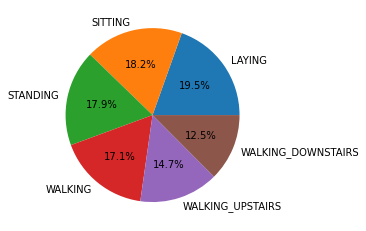

In [3]:
import matplotlib.pyplot as plt
occurences = df['Activity'].value_counts()
plt.pie(occurences, labels = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'], autopct='%1.1f%%')

# Based on the piechart we can see that the data is relatively balanced

In [4]:
# Check the amount of NaNs in a dataset
df.isna().sum().sum()

32636

In [5]:
# Remove NaNs
df_clean = df.dropna()

# Check if NaNs were removed
df_clean.isna().sum().sum()

0

In [6]:
df_clean.shape

(9624, 573)

Text(0.5, 1.0, 'Correlation Matrix between data')

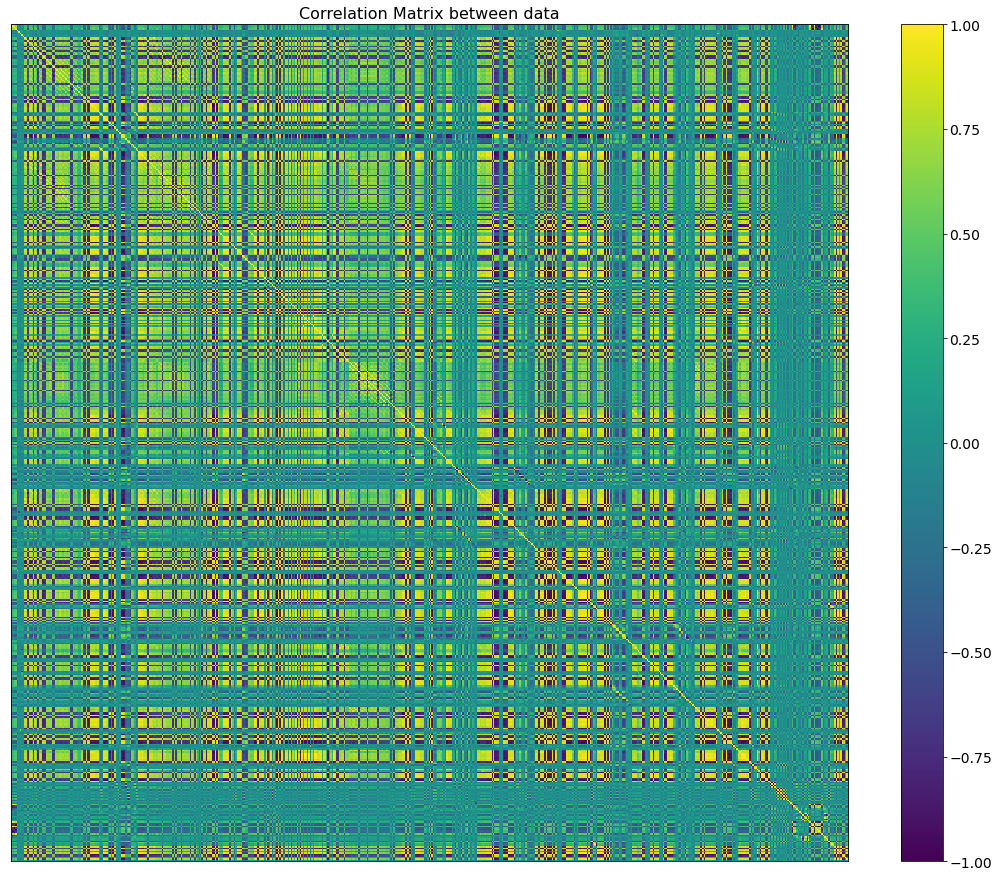

In [7]:
# Visualize the correlation between data
f = plt.figure(figsize=(19, 15))
plt.matshow(df_clean.corr(), fignum=f.number)
plt.xticks(range(df_clean.select_dtypes(['number']).shape[1]), df_clean.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_clean.select_dtypes(['number']).shape[1]), df_clean.select_dtypes(['number']).columns, fontsize=14)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix between data', fontsize=16)

# There are column pairs which are highly correlated

In [8]:
# Remove column containing row numeration
del df_clean["Unnamed: 0"]

# Calculate correlation matrix between columns
cor_matrix = df_clean.corr().abs()

# Drop columns with correlation higher than 0.8
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
df_analysis = df_clean.drop(df[to_drop], axis=1)

In [9]:
df_analysis.shape

(9624, 157)

Text(0.5, 1.0, 'Correlation Matrix between data after removing highly correlated columns')

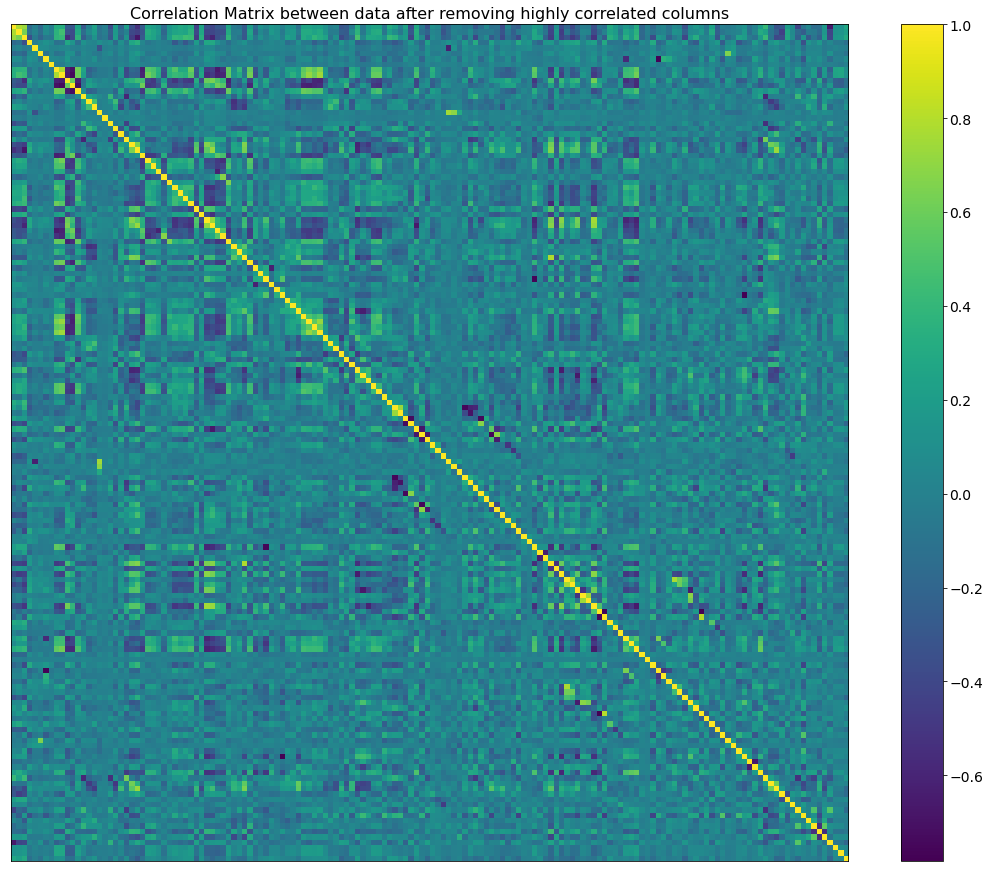

In [10]:
# Visualize the correlation between data after removing highly correlated columns
f = plt.figure(figsize=(19, 15))
plt.matshow(df_analysis.corr(), fignum=f.number)
plt.xticks(range(df_analysis.select_dtypes(['number']).shape[1]), df_analysis.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_analysis.select_dtypes(['number']).shape[1]), df_analysis.select_dtypes(['number']).columns, fontsize=14)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix between data after removing highly correlated columns', fontsize=16)

In [11]:
# Divide dataframe into variables and labels sets
Y_labels = df_analysis['Activity']
X_values = df_analysis.loc[:, df_analysis.columns != 'Activity']
variables = list(X_values.columns.values)

In [12]:
df_analysis.isna().sum().sum()

0

In [13]:
# Descriptive statistics for each column
X_values.describe()

,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)",energy-mean(),"fBodyAcc-bandsEnergy()-1,16","fBodyAcc-bandsEnergy()-1,16.1",...,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-sma(),tGravityAccMag-mad(),tGravityAccMag-sma(),void()
count,9624.000000,9624.000000,9624.000000,9624.000000,9624.000000,9624.000000,9624.000000,9624.000000,9624.000000,9624.000000,...,9624.000000,9624.000000,9624.000000,9624.000000,9624.000000,9624.000000,9624.000000,9624.000000,9624.000000,9624.000000
mean,-1.566967,-0.618666,-2.446406,-1.860302,0.091439,-0.157486,5.299759,-7.725281,2.996309,5.870776,...,8.078945,2.994278,1.887553,4.692596,-1.559531,-0.442244,6.136167,-2.914255,1.200645,2.116064
std,0.009837,0.330825,0.033060,0.070439,0.238769,1.125000,1.972551,4.316315,0.920384,0.386757,...,0.325810,0.433787,0.558917,0.067666,0.041380,0.149868,0.188521,2.435851,2.329634,0.802117
min,-1.577122,-1.839413,-2.562914,-2.012415,-0.702915,-2.689919,1.772903,-12.306239,-3.830384,3.507515,...,6.630538,0.832520,-0.762367,2.735087,-1.584459,-2.563556,5.626012,-6.499224,-2.490387,1.000000
25%,-1.573354,-0.850741,-2.467412,-1.915239,0.024822,-0.887342,3.745513,-11.913196,2.512880,5.682644,...,7.778882,2.957139,1.581763,4.684114,-1.580576,-0.463599,5.993685,-6.080929,-2.025624,1.000000
50%,-1.570925,-0.729617,-2.453145,-1.864997,0.078247,-0.128839,5.607855,-7.282182,3.621230,6.147828,...,8.112279,3.246233,1.966974,4.710395,-1.572898,-0.402542,6.132560,-2.457161,1.427866,2.000000
75%,-1.567930,-0.486540,-2.436827,-1.810647,0.218134,0.611055,6.877864,-4.591316,3.623912,6.158630,...,8.394366,3.246233,2.348895,4.723373,-1.551084,-0.369040,6.290303,-0.548003,3.368734,3.000000
max,-1.536682,0.720197,-2.345198,-1.714677,0.845884,2.393603,8.247982,3.510343,3.624157,6.159275,...,8.394366,3.246233,2.348895,4.731816,-0.361903,-0.354566,6.588141,-0.133978,3.790841,3.000000


In [14]:
# Standardising the data
sc = StandardScaler()
X_values = sc.fit_transform(X_values)

In [15]:
# Dividing data into training and test set taking 80% of prior data as a training set,
X_train, X_test= np.split(X_values, [int(.9 *len(X_values))])
Y_train, Y_test= np.split(Y_labels, [int(.9 *len(Y_labels))])

In [16]:
# Printing shape of our data sets
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', Y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', Y_test.shape)

Training Features Shape: (8661, 156)
Training Labels Shape: (8661,)
Testing Features Shape: (963, 156)
Testing Labels Shape: (963,)


In [17]:
# Function for training the classifier and measuring training time
def train(clf, X_train, Y_train):
    
    # Starting the clock, training the classifier, then stoping the clock
    start = time()
    clf.fit(X_train, Y_train)
    end = time()
    
    # Printing time results
    print ("Model trained in: ",end - start)

In [18]:
# Function for predictions from classifier
def predict(clf, features, target):
    
    # Starting the clock, making predictions, then stoping the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Printing time results
    print ("Prediction made in: ",end - start)
    
    # Returning F1 score, accuracy and predicted labels
    return f1_score(target, y_pred, average=None), sum(target == y_pred) / float(len(y_pred)), y_pred

In [19]:
# Function for evaluation of the classifier
def fit(clf, X_train, y_train, X_test, y_test):
    
    # Indicating the model and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Training the model
    train(clf, X_train, y_train)
    
    # Printing the results of prediction for both train set and test set
    f1, acc, predictions = predict(clf, X_train, y_train)
    print ("===========================================")
    print ("Indexes assesing methods for training set:")
    print ("F1 score [LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS]:", f1)
    print ("Accuracy:", acc)
    
    print ("===========================================")
    f1, acc, predictions = predict(clf, X_test, y_test)
    print ("Indexes assesing methods for test set:")
    print ("F1 score [LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS]:", f1)
    print ("Accuracy:", acc)

## Logistic Regression 

In [20]:
from sklearn.linear_model import LogisticRegression
clf_LR = LogisticRegression(random_state = 458)

fit(clf_LR, X_train, Y_train, X_test, Y_test)
print ('')

Training a LogisticRegression using a training set size of 8661. . .
Model trained in:  0.7199997901916504
Prediction made in:  0.003004789352416992
Indexes assesing methods for training set:
F1 score [LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS]: [1.         0.96169418 0.96121097 1.         1.         1.        ]
Accuracy: 0.9857984066505022
Prediction made in:  0.0020036697387695312
Indexes assesing methods for test set:
F1 score [LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS]: [1.         0.95264624 0.95014663 0.98809524 0.99604743 0.98932384]
Accuracy: 0.9781931464174455



C:\Users\domin\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## XGBoost - training and making predictions

In [21]:
import xgboost as xgb

clf_XGB = xgb.XGBClassifier(seed = 82)

fit(clf_XGB, X_train, Y_train, X_test, Y_test)
print ('')

C:\Users\domin\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training a XGBClassifier using a training set size of 8661. . .
[14:35:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model trained in:  20.950992584228516
Prediction made in:  0.05800032615661621
Indexes assesing methods for training set:
F1 score [LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS]: [1. 1. 1. 1. 1. 1.]
Accuracy: 1.0
Prediction made in:  0.007997989654541016
Indexes assesing methods for test set:
F1 score [LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS]: [1.         0.99453552 0.99404762 0.99701493 0.99206349 0.99644128]
Accuracy: 0.995846313603323



## XGBoost - tunning tests

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Defining parameters we want to tune
parameters = { 'learning_rate' : [0.2],
               'n_estimators' : [150],
               'max_depth': [3,5],
               'min_child_weight': [3],
               'gamma':[0.4],
               'subsample' : [0.8],
               'colsample_bytree' : [0.7] }

# Initializing the classifier
clf_XGB = xgb.XGBClassifier(seed=2)

# Performing grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf_XGB,
                        scoring='f1_macro',
                        param_grid=parameters,
                        cv=5,
                        verbose=1)

grid_obj = grid_obj.fit(X_train, Y_train)

clf_XGB = grid_obj.best_estimator_

# Printing out best found parameters
grid_obj.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\domin\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:36:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\domin\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:36:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\domin\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:36:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\domin\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:36:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\domin\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:37:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\domin\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:37:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\domin\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:37:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\domin\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\domin\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\domin\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\domin\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'colsample_bytree': 0.7,
 'gamma': 0.4,
 'learning_rate': 0.2,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 150,
 'subsample': 0.8}

## XGBoost - making predictions after tunning

In [23]:
#Print the results of prediction for training set after parameter tuning
f1, acc, predictions = predict(clf_XGB, X_train, Y_train)
print ("Indexes assesing methods for training set:")
print ("F1 score [LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS]:", f1)
print ("Accuracy:", acc)

Prediction made in:  0.07899785041809082
Indexes assesing methods for training set:
F1 score [LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS]: [1. 1. 1. 1. 1. 1.]
Accuracy: 1.0


In [24]:
#Print the results of prediction for testing set after parameter tuning
f1, acc, predictions = predict(clf_XGB, X_test, Y_test)
print ("Indexes assesing methods for test set:")
print ("F1 score [LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS]:", f1)
print ("Accuracy:", acc)

# We failed to increase the results of the model, so we decided to abandon tunning, as the results without it are satisfying enough

Prediction made in:  0.024985313415527344
Indexes assesing methods for test set:
F1 score [LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS]: [1.         0.98644986 0.98498498 0.99701493 0.99604743 1.        ]
Accuracy: 0.9937694704049844


In [25]:
# Printing features importance in decreasing order
feature_imp_xg = pd.Series(clf_XGB.feature_importances_,index=variables).sort_values(ascending=False)
feature_imp_xg

fBodyAcc-meanFreq()-Z                 0.132823
fBodyAcc-kurtosis()-X                 0.077427
fBodyAccJerk-bandsEnergy()-57,64.1    0.069302
angle(X,gravityMean)                  0.038379
fBodyAcc-bandsEnergy()-17,24          0.036990
                                        ...   
tBodyGyro-arCoeff()-X,4               0.000190
tBodyGyro-low()-Y                     0.000000
tBodyAcc-arCoeff()-Z,3                0.000000
fBodyAcc-main()-Z                     0.000000
tGravityAccMag-sma()                  0.000000
Length: 156, dtype: float32

<AxesSubplot:>

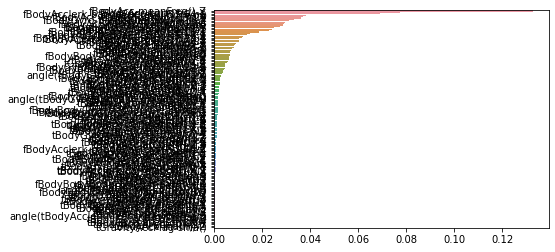

In [26]:
%matplotlib inline

# Plotting features importance
sns.barplot(x=feature_imp_xg, y=feature_imp_xg.index)

## Random Forest - training and making predictions

In [27]:
from sklearn.ensemble import RandomForestClassifier

# Creating a Gaussian Classifier
clf_RF=RandomForestClassifier(n_estimators=100)

# Making predicitons
fit(clf_RF, X_train, Y_train, X_test, Y_test)
print ('')

Training a RandomForestClassifier using a training set size of 8661. . .
Model trained in:  6.083032608032227
Prediction made in:  0.1910090446472168
Indexes assesing methods for training set:
F1 score [LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS]: [1. 1. 1. 1. 1. 1.]
Accuracy: 1.0
Prediction made in:  0.04803943634033203
Indexes assesing methods for test set:
F1 score [LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS]: [1.         0.95628415 0.95238095 0.98214286 0.97637795 0.97122302]
Accuracy: 0.9730010384215991



In [28]:
# Printing features importance in decreasing order
feature_imp = pd.Series(clf_RF.feature_importances_,index=variables).sort_values(ascending=False)
feature_imp

angle(Y,gravityMean)           0.072122
angle(X,gravityMean)           0.066180
angle(Z,gravityMean)           0.038265
fBodyAcc-bandsEnergy()-1,16    0.037689
tBodyAcc-correlation()-X,Y     0.023800
                                 ...   
tBodyAccJerk-arCoeff()-Y,3     0.000735
fBodyAcc-main()-Z              0.000626
energy-mean()                  0.000584
tBodyGyro-low()-Y              0.000534
void()                         0.000230
Length: 156, dtype: float64

<AxesSubplot:>

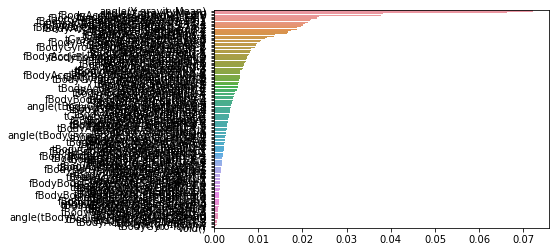

In [29]:
%matplotlib inline
# Plotting features importance
sns.barplot(x=feature_imp, y=feature_imp.index)

## In general results obtained by the XGBoost were the best and we decided to continue our work only with that model also because XGBoost manages NaN values finely.
## Based on the feature importance assigned to the variables by the models we decided to take only the variables with importance higher than 0.005 significantly reducing the size of our dataset

In [30]:
# Load training data once again to perform tests on significantly lower volume dataset
df = pd.read_csv('final_train.csv')

In [31]:
# Remove column containing row numeration
del df["Unnamed: 0"]

# Calculate correlation matrix between columns
cor_matrix = df.corr().abs()

# Drop highest correlated columns
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
df1 = df.drop(df[to_drop], axis=1)
df_analysis = df1

In [32]:
# Divide dataframe into values and labels sets
Y_labels = df_analysis['Activity'] 
X_values = df_analysis[['fBodyAccJerk-bandsEnergy()-57,64.1', 'fBodyAcc-meanFreq()-Z', 
                        'angle(X,gravityMean)', 'fBodyAcc-bandsEnergy()-1,16', 'fBodyGyro-min()-X', 
                        'tBodyAccMag-arCoeff()1', 'fBodyGyro-maxInds-X', 'fBodyAcc-maxInds-X', 
                        'fBodyAcc-bandsEnergy()-17,24', 'fBodyAccMag-maxInds', 'angle(Y,gravityMean)', 
                        'fBodyAccJerk-meanFreq()-Z', 'fBodyAcc-bandsEnergy()-9,16', 'tBodyGyroMag-entropy()', 
                        'fBodyAcc-bandsEnergy()-1,16.2', 'fBodyAcc-min()-Y', 'fBodyGyro-maxInds-Z', 
                        'tBodyGyro-entropy()-X', 'fBodyBodyGyroJerkMag-maxInds', 'tBodyAcc-correlation()-X,Y', 
                        'tBodyGyro-correlation()-Y,Z', 'fBodyAcc-maxInds-Z', 'fBodyAccJerk-min()-X', 
                        'tGravityAcc-arCoeff()-X,1', 'tGravityAcc-arCoeff()-Z,1', 'fBodyAcc-bandsEnergy()-1,16.1']]

In [33]:
# Standardising the data
sc = StandardScaler()
X_values = sc.fit_transform(X_values)

In [34]:
# Dividing data into training and test set taking 80% of prior data as a training set,
# so that our models are tested based on matches that took place after matches from our training set
X_train, X_test= np.split(X_values, [int(.9 *len(X_values))])
Y_train, Y_test= np.split(Y_labels, [int(.9 *len(Y_labels))])

In [35]:
# Printing shape of our data sets
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', Y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', Y_test.shape)

Training Features Shape: (9977, 26)
Training Labels Shape: (9977,)
Testing Features Shape: (1109, 26)
Testing Labels Shape: (1109,)


In [36]:
# Function for inference 
def inference(clf_XGB, inf):
    start = time()
    y_pred = clf_XGB.predict(inf)
    end = time()

    # Printing results
    print ("Inference made in: ",end - start)

In [37]:
# Creating our model and training it
clf_XGB = xgb.XGBClassifier()

fit(clf_XGB, X_train, Y_train, X_test, Y_test)
print ('')

Training a XGBClassifier using a training set size of 9977. . .


C:\Users\domin\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:39:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model trained in:  9.31799578666687
Prediction made in:  0.046002864837646484
Indexes assesing methods for training set:
F1 score [LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS]: [1. 1. 1. 1. 1. 1.]
Accuracy: 1.0
Prediction made in:  0.007999897003173828
Indexes assesing methods for test set:
F1 score [LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS]: [1.         0.95673077 0.95466667 0.98969072 0.9858156  0.99093656]
Accuracy: 0.9792605951307484



In [38]:
# Inference time
pred_try = np.array([X_train[0]])
inference(clf_XGB, pred_try)

Inference made in:  0.004002571105957031


In [39]:
# Saving trained model
clf_XGB.save_model('XGB_classifier.model')

In [40]:
# Loading trained model
clf2 = xgb.XGBClassifier()
clf2.load_model('XGB_classifier.model')

In [41]:
# Printing accuracy of our classifier
f1f, accf, predicted = predict(clf2, X_values, Y_labels)
print("Accuracy after tuning: ", accf)

Prediction made in:  0.06800055503845215
Accuracy after tuning:  0.9979253112033195


In [42]:
np.mean(predicted == df.Activity)

0.9979253112033195